# import required

In [1]:
import face_recognition
from PIL import Image
import numpy as np
import tqdm
from time import time

In [2]:
face_recognition.__version__

'1.2.3'

# Make Encoding of any face image

In [3]:
def get_encoding(img_path):
    try:
        known_image = face_recognition.load_image_file(img_path)
        face=face_recognition.face_locations(known_image,number_of_times_to_upsample=2)
        known_encoding = face_recognition.face_encodings(known_image,known_face_locations=face,num_jitters=1)[0]
        return known_encoding
    except:
        return None

# MySql Functions for db_creation, table_creation, insertion and comparioson of 1 image with all db images

In [4]:
import mysql.connector
import traceback

def make_db(db_name="face_db"):
    try:
        connection = mysql.connector.connect(host='localhost',
                                             user='root',
                                             password='')
        cursor = connection.cursor()

        cursor.execute(f"CREATE DATABASE {db_name}")
        print(f"Successfully {db_name} created!")
    except mysql.connector.Error as error:
        print("Failed to create db! may be db exist".format(error))

    finally:
        if connection.is_connected():
            cursor.close()
            connection.close()
            print("MySQL connection is closed")


def make_table(table_name="face_table"):
    try:
        connection = mysql.connector.connect(host='localhost',
                                             user='root',
                                             password='',
                                             database='face_db')
        cursor = connection.cursor()

        with open('./queries.sql')as f:
            tabel_query=f.read()
        cursor.execute(tabel_query)
        print(f"Successfully {table_name} created!")
    except mysql.connector.Error as error:
        print("Failed to create table! may be table exist ".format(error))
    finally:
        if connection.is_connected():
            cursor.close()
            connection.close()
            print("MySQL connection is closed")

def insert_record_into_table(request_id, client_id, encoding):
    try:
        connection = mysql.connector.connect(host='localhost',
                                             user='root',
                                             password='',
                                             database='face_db',)
        cursor = connection.cursor()
        mySql_insert_query = f'''INSERT INTO face_table 
        (request_id,client_id,{','.join([f'e{i}' for i in range(1,129)])})
        VALUES({request_id},{client_id},{','.join([str(i) for i in encoding])})
        '''
        cursor.execute(mySql_insert_query)
        connection.commit()
#         print("Record inserted successfully into Laptop table")

    except mysql.connector.Error as error:
        print("Failed to insert into MySQL table {}".format(error))

    finally:
        if connection.is_connected():
            cursor.close()
            connection.close()
#             print("MySQL connection is closed")

def compare_from_table(encoding,threshold=0.55):
    try:
        connection = mysql.connector.connect(host='localhost',
                                             user='root',
                                             password='',
                                             database='face_db',)
        cursor = connection.cursor()
        mySql_comparison_query = f'''
        SELECT request_id,client_id,sqrt({'+'.join([f"power(e{idx+1} - {i}, 2)" for idx,i in enumerate(encoding)])}) from face_table where 
        sqrt({'+'.join([f"power(e{idx+1} - {i}, 2)" for idx,i in enumerate(encoding)])})<{threshold}'''
#         print(mySql_comparison_query)
        cursor.execute(mySql_comparison_query)
        records=cursor.fetchall()
        print("query_executed!")
        return records
    except mysql.connector.Error as error:
        print("Failed to insert into MySQL table {}".format(error))

    finally:
        if connection.is_connected():
            cursor.close()
            connection.close()
            print("MySQL connection is closed")



## make db 

In [5]:
make_db(db_name='face_db')


Failed to create db! may db exist
MySQL connection is closed


## make table

In [6]:
make_table(table_name="face_table")

Failed to create table! may table exist 
MySQL connection is closed


## make image encoding

128


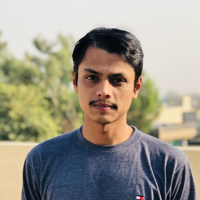

In [7]:
img_path = './test.jpg'
known_encoding=get_encoding(img_path)
if type(known_encoding)==np.ndarray:
    print(len(known_encoding))
    display(Image.open(img_path).resize((200,200)))
else:
    print('no_encoding_find!')
    display(Image.open(img_path).resize((200,200)))

## insert record

In [ ]:
insert_record_into_table(request_id=100000002, client_id=1, encoding=known_encoding)

## make encoding 

In [ ]:
img_path = './4.jpg'
known_encoding=get_encoding(img_path)
if type(known_encoding)==np.ndarray:
    print(len(known_encoding))
    display(Image.open(img_path).resize((200,200)))
else:
    print('no_encoding_find!')
    display(Image.open(img_path).resize((200,200)))

## compare encoding with db encodings

In [8]:
start=time()
display(compare_from_table(known_encoding,0.5))
time()-start

query_executed!
MySQL connection is closed


[]

75.93190932273865

# Insert fake records

In [ ]:
def insertion(i):
    insert_record_into_table(request_id=i, client_id=1, encoding=np.random.random_sample(128))


In [ ]:
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import as_completed

with ThreadPoolExecutor(max_workers = 50) as executor:
    executor.map(insertion, list(range(200000,1000000)))


In [ ]:
from psycopg2.pool import SimpleConnectionPool
from contextlib import contextmanager

In [ ]:
hostname = 'localhost'
dbname = 'face_db'
dbuser = 'root'
dbpass = ''

db = SimpleConnectionPool(1, 10,host=hostname,database=dbname,user=dbuser,  
password=dbpass)

@contextmanager
def get_connection():
    con = db.getconn()
    try:
        yield con
    finally:
        db.putconn(con)

In [ ]:
def saveDb(request_id, client_id, face_encodings):

    with get_connection() as conn:
        try:
            cursor = conn.cursor()
            query = "INSERT INTO encodings(request_id, client_id, encodevector) VALUES ('{}','{}', CUBE(array[{}]))".format(request_id, client_id, ','.join(str(s) for s in face_encodings))
            cursor.execute(query) 
            cursor.close()
            conn.commit()
            return 1
        except:
            conn.rollback()
            return 0

In [ ]:
def findDb(face_encodings, threshold=0.55):
    with get_connection() as conn:
        try:
            name = 'Unknown'
            empid = '0000000'
            cursor = conn.cursor()            
            query = "SELECT request_id, client_id FROM encodings WHERE sqrt(power(CUBE(array[{}]) <-> encodevector, 2)) <= {} ".format(','.join(str(s) for s in face_encodings), threshold) + "ORDER BY sqrt(power(CUBE(array[{}]) <-> encodevector, 2)) ASC LIMIT 1".format(','.join(str(s) for s in face_encodings))
            cursor.execute(query)
            data = cursor.fetchone()
            if data == None:
                return name, empid
            else:
                return data
        except Exception as e:
            return e

In [ ]:
def test(face_encodings):
    return query = "SELECT request_id, client_id FROM encodings WHERE sqrt(power(CUBE(array[{}]) <-> encodevector, 2)) <= {} "\
.format(','.join(str(s) for s in face_encodings), threshold) + "ORDER BY sqrt(power(CUBE(array[{}]) <-> encodevector, 2)) ASC LIMIT 1".format(','.join(str(s) for s in face_encodings))


